### Install project

In [1]:
!git clone https://github.com/kornelro/cv_project.git

Cloning into 'cv_project'...
remote: Enumerating objects: 298, done.
remote: Counting objects: 100% (298/298), done.
remote: Compressing objects: 100% (199/199), done.
remote: Total 576 (delta 99), reused 202 (delta 53), pack-reused 278
Receiving objects: 100% (576/576), 97.21 MiB | 34.02 MiB/s, done.
Resolving deltas: 100% (245/245), done.


In [2]:
!pip install cv_project/.

Processing ./cv_project
  Created wheel for src: filename=src-0.1.0-cp36-none-any.whl size=16310 sha256=e9d8336f48fa996cb9a5ee544fcbffe4c9260aabaed19880c205883680a3ea8c
  Stored in directory: /tmp/pip-ephem-wheel-cache-rt2n772g/wheels/fc/1b/40/72379bece2bafba26136079aeac87421c9221abafeb9c66746
Successfully built src


### Mount drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
DRIVE_PATH = '/content/drive/Shareddrives/CV-PROJECT/'

### Imports

In [5]:
pip install stellargraph

     |████████████████████████████████| 440kB 16.7MB/s 


In [13]:
import pickle
import numpy as np
import tensorflow.keras as K
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from stellargraph.utils.history import plot_history

from src.data.make_dataset import make_dataset
from src.data.image_loaders import VehiculesFixedSizeImageLoader
from src.data.dataset_loaders import VehiculesDatasetLoader
from src.features.pipelines import RawImageToImage
from src.features.processors import NormImage
from src.models.classifiers import ResnetModelWrapper
from src.models.detectors import SliderProbDetector
from src.data.sliders import SlidingWindow
from src.evaluation import validate_model, precision, recall, f1_score

# Vehicules
# ResNet50
# Pipeline: Norm

### Load dataset

In [7]:
DATA_PATH = DRIVE_PATH+'data/processed/vehicules/resnet/data_resnet.pickle'

In [8]:
with open(DATA_PATH, 'rb') as f:
    data = pickle.load(f)

### Train ResNet50

In [9]:
TEST_SIZE = 0.1
BATCH_SIZE = 100
EPOCHS = 5

In [10]:
X = np.array(list(map(lambda x: x[1], data)))
y = np.array(list(map(lambda x: x[2], data)))
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=TEST_SIZE,
    random_state=42
  )


input_t = K.Input(shape=(X[0].shape))
res_model = K.applications.ResNet50V2(
    include_top=False,
    weights='imagenet',
    input_tensor=input_t
)

for layer in res_model.layers:
    layer.trainable = False

model = K.models.Sequential()
model.add(res_model)
model.add(K.layers.Flatten())
model.add(K.layers.Dense(2, activation='softmax'))


model.compile(
    optimizer=K.optimizers.Adam(0.001),
    loss=K.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

history = model.fit(X_train, y_train,
            batch_size=BATCH_SIZE,
            epochs=EPOCHS, 
            validation_data=(X_test, y_test)
)

94674944/94668760 [==============================] - 0s 0us/step
Epoch 1/5
85/85 [==============================] - 14s 49ms/step - loss: 0.2147 - accuracy: 0.9191 - val_loss: 0.0985 - val_accuracy: 0.9682
Epoch 2/5
85/85 [==============================] - 2s 27ms/step - loss: 0.0610 - accuracy: 0.9816 - val_loss: 0.0991 - val_accuracy: 0.9682
Epoch 3/5
85/85 [==============================] - 2s 27ms/step - loss: 0.0376 - accuracy: 0.9871 - val_loss: 0.0775 - val_accuracy: 0.9724
Epoch 4/5
85/85 [==============================] - 2s 27ms/step - loss: 0.0224 - accuracy: 0.9953 - val_loss: 0.0787 - val_accuracy: 0.9756
Epoch 5/5
85/85 [==============================] - 2s 27ms/step - loss: 0.0186 - accuracy: 0.9950 - val_loss: 0.0762 - val_accuracy: 0.9766


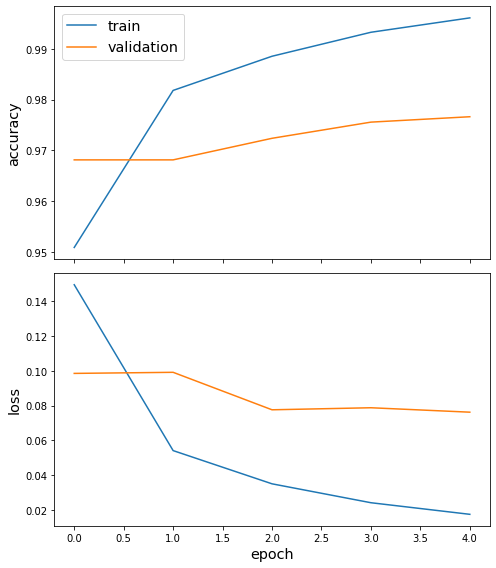

In [11]:
plot_history(history)

### Validation

In [14]:
del data

In [15]:
BND_BOX_SIZE = (50, 50)
STEP_SIZE = 20

dataset_loader = VehiculesDatasetLoader(
    image_loader=VehiculesFixedSizeImageLoader(
        bnd_box_size=BND_BOX_SIZE
    )
)

process_pipeline=RawImageToImage(
    processors=[
        NormImage()
    ]
)

sliding_window = SlidingWindow(
    step_size=STEP_SIZE,
    window_size=BND_BOX_SIZE
)

treshold = 0.7; nms_overlap=0.4


In [17]:
slider_detector = SliderProbDetector(
    sliding_window=sliding_window,
    process_pipeline=process_pipeline,
    classifier=ResnetModelWrapper(model),
    treshold=0.7,
    nms_overlap=0.4
)

true_positives, false_positives, false_negatives, processed_images = validate_model(
    dataset_loader=dataset_loader,
    input_folder_filepath=DRIVE_PATH+'data/raw/vehicules/val',
    output_folder_filepath=DRIVE_PATH+'processed_images/resnet50/vehicules/norm/t7nms4',
    images_files_types=('png',),
    annotations_files_types=('txt',),
    detector=slider_detector,
    workers=0
)

print()
print('Precision:',  round(precision(true_positives, false_positives), 3))
print('Recall:',  round(recall(true_positives, false_negatives), 3))
print('F1Score:', round(f1_score(true_positives, false_positives, false_negatives), 3))

No file /content/drive/Shareddrives/CV-PROJECT/data/raw/vehicules/val/00001185.txt
No file /content/drive/Shareddrives/CV-PROJECT/data/raw/vehicules/val/00001143.txt
No file /content/drive/Shareddrives/CV-PROJECT/data/raw/vehicules/val/00001248.txt
No file /content/drive/Shareddrives/CV-PROJECT/data/raw/vehicules/val/00001244.txt
No file /content/drive/Shareddrives/CV-PROJECT/data/raw/vehicules/val/00001145.txt



  2%|▏         | 1/66 [00:01<01:50,  1.70s/it]

26



  3%|▎         | 2/66 [00:03<01:46,  1.66s/it]

9



  5%|▍         | 3/66 [00:04<01:42,  1.62s/it]

7



  6%|▌         | 4/66 [00:06<01:38,  1.60s/it]

12



  8%|▊         | 5/66 [00:07<01:36,  1.58s/it]

14



  9%|▉         | 6/66 [00:09<01:37,  1.63s/it]

10



 11%|█         | 7/66 [00:11<01:34,  1.60s/it]

21



 12%|█▏        | 8/66 [00:12<01:32,  1.59s/it]

37



 14%|█▎        | 9/66 [00:14<01:29,  1.58s/it]

27



 15%|█▌        | 10/66 [00:15<01:27,  1.57s/it]

61



 17%|█▋        | 11/66 [00:17<01:26,  1.58s/it]

11



 18%|█▊        | 12/66 [00:19<01:25,  1.59s/it]

72



 20%|█▉        | 13/66 [00:20<01:24,  1.59s/it]

26



 21%|██        | 14/66 [00:22<01:22,  1.58s/it]

24



 23%|██▎       | 15/66 [00:23<01:20,  1.59s/it]

9



 24%|██▍       | 16/66 [00:25<01:19,  1.58s/it]

11



 26%|██▌       | 17/66 [00:26<01:16,  1.57s/it]

30



 27%|██▋       | 18/66 [00:28<01:15,  1.57s/it]

14



 29%|██▉       | 19/66 [00:30<01:13,  1.57s/it]

12



 30%|███       | 20/66 [00:31<01:11,  1.56s/it]

26



 32%|███▏      | 21/66 [00:33<01:10,  1.57s/it]

29



 33%|███▎      | 22/66 [00:34<01:09,  1.58s/it]

8



 35%|███▍      | 23/66 [00:36<01:07,  1.57s/it]

102



 36%|███▋      | 24/66 [00:37<01:05,  1.57s/it]

24



 38%|███▊      | 25/66 [00:39<01:04,  1.57s/it]

10



 39%|███▉      | 26/66 [00:41<01:03,  1.58s/it]

21



 41%|████      | 27/66 [00:42<01:01,  1.59s/it]

22



 42%|████▏     | 28/66 [00:44<01:00,  1.59s/it]

45



 44%|████▍     | 29/66 [00:45<00:59,  1.60s/it]

11



 45%|████▌     | 30/66 [00:47<00:57,  1.59s/it]

3



 47%|████▋     | 31/66 [00:48<00:55,  1.58s/it]

38



 48%|████▊     | 32/66 [00:50<00:53,  1.57s/it]

10



 50%|█████     | 33/66 [00:52<00:51,  1.57s/it]

4



 52%|█████▏    | 34/66 [00:53<00:50,  1.59s/it]

9



 53%|█████▎    | 35/66 [00:55<00:49,  1.60s/it]

44



 55%|█████▍    | 36/66 [00:56<00:47,  1.58s/it]

12



 56%|█████▌    | 37/66 [00:58<00:46,  1.61s/it]

5



 58%|█████▊    | 38/66 [01:00<00:44,  1.60s/it]

3



 59%|█████▉    | 39/66 [01:01<00:43,  1.59s/it]

20



 61%|██████    | 40/66 [01:03<00:41,  1.59s/it]

9



 62%|██████▏   | 41/66 [01:04<00:40,  1.60s/it]

7



 64%|██████▎   | 42/66 [01:06<00:38,  1.60s/it]

26



 65%|██████▌   | 43/66 [01:08<00:36,  1.60s/it]

55



 67%|██████▋   | 44/66 [01:09<00:35,  1.60s/it]

21



 68%|██████▊   | 45/66 [01:11<00:33,  1.60s/it]

13



 70%|██████▉   | 46/66 [01:12<00:31,  1.58s/it]

5



 71%|███████   | 47/66 [01:14<00:29,  1.57s/it]

12



 73%|███████▎  | 48/66 [01:16<00:28,  1.57s/it]

53



 74%|███████▍  | 49/66 [01:17<00:26,  1.58s/it]

82



 76%|███████▌  | 50/66 [01:19<00:25,  1.59s/it]

22



 77%|███████▋  | 51/66 [01:20<00:23,  1.59s/it]

10



 79%|███████▉  | 52/66 [01:22<00:22,  1.59s/it]

22



 80%|████████  | 53/66 [01:23<00:20,  1.58s/it]

11



 82%|████████▏ | 54/66 [01:25<00:18,  1.58s/it]

14



 83%|████████▎ | 55/66 [01:27<00:17,  1.58s/it]

44



 85%|████████▍ | 56/66 [01:28<00:15,  1.57s/it]

32



 86%|████████▋ | 57/66 [01:30<00:14,  1.57s/it]

3



 88%|████████▊ | 58/66 [01:31<00:12,  1.57s/it]

6



 89%|████████▉ | 59/66 [01:33<00:11,  1.58s/it]

40



 91%|█████████ | 60/66 [01:34<00:09,  1.58s/it]

10



 92%|█████████▏| 61/66 [01:36<00:07,  1.59s/it]

7



 94%|█████████▍| 62/66 [01:38<00:06,  1.58s/it]

26



 95%|█████████▌| 63/66 [01:39<00:04,  1.59s/it]

22



 97%|█████████▋| 64/66 [01:41<00:03,  1.58s/it]

16



 98%|█████████▊| 65/66 [01:42<00:01,  1.57s/it]

12



100%|██████████| 66/66 [01:44<00:00,  1.58s/it]

15



Precision: 0.081
Recall: 0.847
F1Score: 0.148


treshold = 0.8; nms_overlap=0.4

In [18]:
del processed_images

In [19]:
slider_detector = SliderProbDetector(
    sliding_window=sliding_window,
    process_pipeline=process_pipeline,
    classifier=ResnetModelWrapper(model),
    treshold=0.8,
    nms_overlap=0.4
)

true_positives, false_positives, false_negatives, processed_images = validate_model(
    dataset_loader=dataset_loader,
    input_folder_filepath=DRIVE_PATH+'data/raw/vehicules/val',
    output_folder_filepath=DRIVE_PATH+'processed_images/resnet50/vehicules/norm/t8nms4',
    images_files_types=('png',),
    annotations_files_types=('txt',),
    detector=slider_detector,
    workers=0
)

print()
print('Precision:',  round(precision(true_positives, false_positives), 3))
print('Recall:',  round(recall(true_positives, false_negatives), 3))
print('F1Score:', round(f1_score(true_positives, false_positives, false_negatives), 3))

No file /content/drive/Shareddrives/CV-PROJECT/data/raw/vehicules/val/00001185.txt
No file /content/drive/Shareddrives/CV-PROJECT/data/raw/vehicules/val/00001143.txt
No file /content/drive/Shareddrives/CV-PROJECT/data/raw/vehicules/val/00001248.txt
No file /content/drive/Shareddrives/CV-PROJECT/data/raw/vehicules/val/00001244.txt
No file /content/drive/Shareddrives/CV-PROJECT/data/raw/vehicules/val/00001145.txt



  2%|▏         | 1/66 [00:01<02:05,  1.93s/it]

23



  3%|▎         | 2/66 [00:03<01:57,  1.83s/it]

9



  5%|▍         | 3/66 [00:05<01:50,  1.75s/it]

7



  6%|▌         | 4/66 [00:06<01:44,  1.69s/it]

10



  8%|▊         | 5/66 [00:08<01:40,  1.65s/it]

10



  9%|▉         | 6/66 [00:09<01:36,  1.62s/it]

9



 11%|█         | 7/66 [00:11<01:34,  1.59s/it]

19



 12%|█▏        | 8/66 [00:12<01:32,  1.59s/it]

30



 14%|█▎        | 9/66 [00:14<01:30,  1.58s/it]

23



 15%|█▌        | 10/66 [00:15<01:28,  1.57s/it]

49



 17%|█▋        | 11/66 [00:17<01:25,  1.56s/it]

9



 18%|█▊        | 12/66 [00:19<01:24,  1.57s/it]

65



 20%|█▉        | 13/66 [00:20<01:23,  1.58s/it]

24



 21%|██        | 14/66 [00:22<01:21,  1.57s/it]

21



 23%|██▎       | 15/66 [00:23<01:20,  1.57s/it]

9



 24%|██▍       | 16/66 [00:25<01:17,  1.56s/it]

10



 26%|██▌       | 17/66 [00:26<01:16,  1.55s/it]

23



 27%|██▋       | 18/66 [00:28<01:14,  1.56s/it]

9



 29%|██▉       | 19/66 [00:30<01:13,  1.57s/it]

9



 30%|███       | 20/66 [00:31<01:11,  1.56s/it]

22



 32%|███▏      | 21/66 [00:33<01:10,  1.56s/it]

25



 33%|███▎      | 22/66 [00:34<01:08,  1.56s/it]

6



 35%|███▍      | 23/66 [00:36<01:07,  1.56s/it]

84



 36%|███▋      | 24/66 [00:37<01:05,  1.55s/it]

16



 38%|███▊      | 25/66 [00:39<01:03,  1.55s/it]

9



 39%|███▉      | 26/66 [00:40<01:02,  1.55s/it]

17



 41%|████      | 27/66 [00:42<01:00,  1.55s/it]

15



 42%|████▏     | 28/66 [00:44<00:59,  1.56s/it]

36



 44%|████▍     | 29/66 [00:45<00:57,  1.56s/it]

11



 45%|████▌     | 30/66 [00:47<00:56,  1.57s/it]

3



 47%|████▋     | 31/66 [00:48<00:55,  1.58s/it]

34



 48%|████▊     | 32/66 [00:50<00:53,  1.57s/it]

9



 50%|█████     | 33/66 [00:51<00:51,  1.57s/it]

2



 52%|█████▏    | 34/66 [00:53<00:50,  1.57s/it]

8



 53%|█████▎    | 35/66 [00:55<00:49,  1.59s/it]

38



 55%|█████▍    | 36/66 [00:56<00:47,  1.59s/it]

11



 56%|█████▌    | 37/66 [00:58<00:45,  1.58s/it]

4



 58%|█████▊    | 38/66 [00:59<00:44,  1.58s/it]

3



 59%|█████▉    | 39/66 [01:01<00:42,  1.58s/it]

14



 61%|██████    | 40/66 [01:03<00:41,  1.59s/it]

7



 62%|██████▏   | 41/66 [01:04<00:39,  1.59s/it]

5



 64%|██████▎   | 42/66 [01:06<00:38,  1.60s/it]

21



 65%|██████▌   | 43/66 [01:07<00:36,  1.59s/it]

47



 67%|██████▋   | 44/66 [01:09<00:35,  1.59s/it]

19



 68%|██████▊   | 45/66 [01:11<00:33,  1.61s/it]

13



 70%|██████▉   | 46/66 [01:12<00:32,  1.62s/it]

5



 71%|███████   | 47/66 [01:14<00:30,  1.62s/it]

10



 73%|███████▎  | 48/66 [01:15<00:29,  1.62s/it]

47



 74%|███████▍  | 49/66 [01:17<00:27,  1.63s/it]

69



 76%|███████▌  | 50/66 [01:19<00:26,  1.64s/it]

19



 77%|███████▋  | 51/66 [01:20<00:24,  1.64s/it]

8



 79%|███████▉  | 52/66 [01:22<00:22,  1.63s/it]

19



 80%|████████  | 53/66 [01:24<00:21,  1.63s/it]

9



 82%|████████▏ | 54/66 [01:25<00:19,  1.63s/it]

13



 83%|████████▎ | 55/66 [01:27<00:17,  1.62s/it]

37



 85%|████████▍ | 56/66 [01:29<00:16,  1.62s/it]

30



 86%|████████▋ | 57/66 [01:30<00:14,  1.61s/it]

2



 88%|████████▊ | 58/66 [01:32<00:12,  1.61s/it]

6



 89%|████████▉ | 59/66 [01:33<00:11,  1.61s/it]

36



 91%|█████████ | 60/66 [01:35<00:09,  1.61s/it]

6



 92%|█████████▏| 61/66 [01:37<00:08,  1.62s/it]

7



 94%|█████████▍| 62/66 [01:38<00:06,  1.68s/it]

23



 95%|█████████▌| 63/66 [01:40<00:04,  1.65s/it]

17



 97%|█████████▋| 64/66 [01:42<00:03,  1.63s/it]

13



 98%|█████████▊| 65/66 [01:43<00:01,  1.62s/it]

11



100%|██████████| 66/66 [01:45<00:00,  1.59s/it]

14



Precision: 0.094
Recall: 0.835
F1Score: 0.169


treshold = 0.9; nms_overlap=0.4

In [20]:
del processed_images

In [21]:
slider_detector = SliderProbDetector(
    sliding_window=sliding_window,
    process_pipeline=process_pipeline,
    classifier=ResnetModelWrapper(model),
    treshold=0.9,
    nms_overlap=0.4
)

true_positives, false_positives, false_negatives, processed_images = validate_model(
    dataset_loader=dataset_loader,
    input_folder_filepath=DRIVE_PATH+'data/raw/vehicules/val',
    output_folder_filepath=DRIVE_PATH+'processed_images/resnet50/vehicules/norm/t9nms4',
    images_files_types=('png',),
    annotations_files_types=('txt',),
    detector=slider_detector,
    workers=0
)

print()
print('Precision:',  round(precision(true_positives, false_positives), 3))
print('Recall:',  round(recall(true_positives, false_negatives), 3))
print('F1Score:', round(f1_score(true_positives, false_positives, false_negatives), 3))

No file /content/drive/Shareddrives/CV-PROJECT/data/raw/vehicules/val/00001185.txt
No file /content/drive/Shareddrives/CV-PROJECT/data/raw/vehicules/val/00001143.txt
No file /content/drive/Shareddrives/CV-PROJECT/data/raw/vehicules/val/00001248.txt
No file /content/drive/Shareddrives/CV-PROJECT/data/raw/vehicules/val/00001244.txt
No file /content/drive/Shareddrives/CV-PROJECT/data/raw/vehicules/val/00001145.txt



  2%|▏         | 1/66 [00:01<01:52,  1.73s/it]

20



  3%|▎         | 2/66 [00:03<01:49,  1.71s/it]

9



  5%|▍         | 3/66 [00:04<01:45,  1.68s/it]

5



  6%|▌         | 4/66 [00:06<01:41,  1.64s/it]

9



  8%|▊         | 5/66 [00:08<01:39,  1.63s/it]

7



  9%|▉         | 6/66 [00:09<01:36,  1.61s/it]

9



 11%|█         | 7/66 [00:11<01:34,  1.60s/it]

15



 12%|█▏        | 8/66 [00:12<01:32,  1.59s/it]

22



 14%|█▎        | 9/66 [00:14<01:30,  1.59s/it]

20



 15%|█▌        | 10/66 [00:16<01:29,  1.59s/it]

35



 17%|█▋        | 11/66 [00:17<01:27,  1.59s/it]

6



 18%|█▊        | 12/66 [00:19<01:25,  1.59s/it]

52



 20%|█▉        | 13/66 [00:20<01:24,  1.59s/it]

20



 21%|██        | 14/66 [00:22<01:23,  1.60s/it]

16



 23%|██▎       | 15/66 [00:24<01:21,  1.60s/it]

9



 24%|██▍       | 16/66 [00:25<01:20,  1.61s/it]

7



 26%|██▌       | 17/66 [00:27<01:19,  1.61s/it]

18



 27%|██▋       | 18/66 [00:28<01:17,  1.61s/it]

7



 29%|██▉       | 19/66 [00:30<01:15,  1.61s/it]

8



 30%|███       | 20/66 [00:32<01:14,  1.61s/it]

20



 32%|███▏      | 21/66 [00:33<01:12,  1.61s/it]

15



 33%|███▎      | 22/66 [00:35<01:10,  1.61s/it]

5



 35%|███▍      | 23/66 [00:36<01:08,  1.60s/it]

65



 36%|███▋      | 24/66 [00:38<01:07,  1.60s/it]

13



 38%|███▊      | 25/66 [00:40<01:05,  1.60s/it]

8



 39%|███▉      | 26/66 [00:41<01:03,  1.60s/it]

8



 41%|████      | 27/66 [00:43<01:02,  1.61s/it]

11



 42%|████▏     | 28/66 [00:44<01:01,  1.61s/it]

31



 44%|████▍     | 29/66 [00:46<01:00,  1.63s/it]

10



 45%|████▌     | 30/66 [00:48<00:58,  1.63s/it]

3



 47%|████▋     | 31/66 [00:49<00:57,  1.63s/it]

24



 48%|████▊     | 32/66 [00:51<00:55,  1.63s/it]

6



 50%|█████     | 33/66 [00:53<00:53,  1.62s/it]

2



 52%|█████▏    | 34/66 [00:54<00:51,  1.61s/it]

6



 53%|█████▎    | 35/66 [00:56<00:49,  1.59s/it]

30



 55%|█████▍    | 36/66 [00:57<00:47,  1.58s/it]

10



 56%|█████▌    | 37/66 [00:59<00:46,  1.60s/it]

3



 58%|█████▊    | 38/66 [01:01<00:44,  1.59s/it]

3



 59%|█████▉    | 39/66 [01:02<00:43,  1.59s/it]

10



 61%|██████    | 40/66 [01:04<00:41,  1.58s/it]

6



 62%|██████▏   | 41/66 [01:05<00:39,  1.58s/it]

5



 64%|██████▎   | 42/66 [01:07<00:37,  1.57s/it]

14



 65%|██████▌   | 43/66 [01:08<00:36,  1.57s/it]

38



 67%|██████▋   | 44/66 [01:10<00:34,  1.57s/it]

16



 68%|██████▊   | 45/66 [01:12<00:32,  1.57s/it]

10



 70%|██████▉   | 46/66 [01:13<00:31,  1.56s/it]

5



 71%|███████   | 47/66 [01:15<00:29,  1.57s/it]

9



 73%|███████▎  | 48/66 [01:16<00:28,  1.58s/it]

35



 74%|███████▍  | 49/66 [01:18<00:26,  1.58s/it]

54



 76%|███████▌  | 50/66 [01:19<00:25,  1.59s/it]

14



 77%|███████▋  | 51/66 [01:21<00:23,  1.58s/it]

5



 79%|███████▉  | 52/66 [01:23<00:22,  1.59s/it]

15



 80%|████████  | 53/66 [01:24<00:20,  1.59s/it]

6



 82%|████████▏ | 54/66 [01:26<00:19,  1.59s/it]

9



 83%|████████▎ | 55/66 [01:27<00:17,  1.60s/it]

29



 85%|████████▍ | 56/66 [01:29<00:16,  1.60s/it]

22



 86%|████████▋ | 57/66 [01:31<00:15,  1.67s/it]

2



 88%|████████▊ | 58/66 [01:32<00:13,  1.66s/it]

6



 89%|████████▉ | 59/66 [01:34<00:11,  1.65s/it]

29



 91%|█████████ | 60/66 [01:36<00:09,  1.64s/it]

5



 92%|█████████▏| 61/66 [01:37<00:08,  1.62s/it]

6



 94%|█████████▍| 62/66 [01:39<00:06,  1.62s/it]

19



 95%|█████████▌| 63/66 [01:40<00:04,  1.60s/it]

12



 97%|█████████▋| 64/66 [01:42<00:03,  1.60s/it]

10



 98%|█████████▊| 65/66 [01:44<00:01,  1.60s/it]

9



100%|██████████| 66/66 [01:45<00:00,  1.60s/it]

13



Precision: 0.117
Recall: 0.824
F1Score: 0.205


treshold = 0.9; nms_overlap=0.3

In [22]:
del processed_images

In [23]:
slider_detector = SliderProbDetector(
    sliding_window=sliding_window,
    process_pipeline=process_pipeline,
    classifier=ResnetModelWrapper(model),
    treshold=0.9,
    nms_overlap=0.3
)

true_positives, false_positives, false_negatives, processed_images = validate_model(
    dataset_loader=dataset_loader,
    input_folder_filepath=DRIVE_PATH+'data/raw/vehicules/val',
    output_folder_filepath=DRIVE_PATH+'processed_images/resnet50/vehicules/norm/t9nms3',
    images_files_types=('png',),
    annotations_files_types=('txt',),
    detector=slider_detector,
    workers=0
)

print()
print('Precision:',  round(precision(true_positives, false_positives), 3))
print('Recall:',  round(recall(true_positives, false_negatives), 3))
print('F1Score:', round(f1_score(true_positives, false_positives, false_negatives), 3))

No file /content/drive/Shareddrives/CV-PROJECT/data/raw/vehicules/val/00001185.txt
No file /content/drive/Shareddrives/CV-PROJECT/data/raw/vehicules/val/00001143.txt
No file /content/drive/Shareddrives/CV-PROJECT/data/raw/vehicules/val/00001248.txt
No file /content/drive/Shareddrives/CV-PROJECT/data/raw/vehicules/val/00001244.txt
No file /content/drive/Shareddrives/CV-PROJECT/data/raw/vehicules/val/00001145.txt



  2%|▏         | 1/66 [00:01<01:50,  1.70s/it]

20



  3%|▎         | 2/66 [00:03<01:46,  1.66s/it]

9



  5%|▍         | 3/66 [00:04<01:44,  1.65s/it]

5



  6%|▌         | 4/66 [00:06<01:40,  1.63s/it]

9



  8%|▊         | 5/66 [00:08<01:38,  1.62s/it]

7



  9%|▉         | 6/66 [00:09<01:35,  1.60s/it]

9



 11%|█         | 7/66 [00:11<01:34,  1.60s/it]

15



 12%|█▏        | 8/66 [00:12<01:33,  1.60s/it]

22



 14%|█▎        | 9/66 [00:14<01:31,  1.60s/it]

20



 15%|█▌        | 10/66 [00:16<01:29,  1.60s/it]

35



 17%|█▋        | 11/66 [00:17<01:28,  1.60s/it]

6



 18%|█▊        | 12/66 [00:19<01:26,  1.60s/it]

52



 20%|█▉        | 13/66 [00:20<01:24,  1.59s/it]

20



 21%|██        | 14/66 [00:22<01:22,  1.59s/it]

16



 23%|██▎       | 15/66 [00:24<01:21,  1.60s/it]

9



 24%|██▍       | 16/66 [00:25<01:19,  1.60s/it]

7



 26%|██▌       | 17/66 [00:27<01:18,  1.60s/it]

18



 27%|██▋       | 18/66 [00:28<01:16,  1.60s/it]

7



 29%|██▉       | 19/66 [00:30<01:15,  1.60s/it]

8



 30%|███       | 20/66 [00:32<01:13,  1.60s/it]

20



 32%|███▏      | 21/66 [00:33<01:12,  1.60s/it]

15



 33%|███▎      | 22/66 [00:35<01:10,  1.60s/it]

5



 35%|███▍      | 23/66 [00:36<01:09,  1.61s/it]

65



 36%|███▋      | 24/66 [00:38<01:07,  1.60s/it]

13



 38%|███▊      | 25/66 [00:40<01:05,  1.60s/it]

8



 39%|███▉      | 26/66 [00:41<01:03,  1.59s/it]

8



 41%|████      | 27/66 [00:43<01:02,  1.60s/it]

11



 42%|████▏     | 28/66 [00:44<01:00,  1.60s/it]

31



 44%|████▍     | 29/66 [00:46<00:58,  1.59s/it]

10



 45%|████▌     | 30/66 [00:47<00:57,  1.59s/it]

3



 47%|████▋     | 31/66 [00:49<00:55,  1.59s/it]

24



 48%|████▊     | 32/66 [00:51<00:53,  1.59s/it]

6



 50%|█████     | 33/66 [00:52<00:52,  1.59s/it]

2



 52%|█████▏    | 34/66 [00:54<00:51,  1.60s/it]

6



 53%|█████▎    | 35/66 [00:55<00:49,  1.60s/it]

30



 55%|█████▍    | 36/66 [00:57<00:48,  1.61s/it]

10



 56%|█████▌    | 37/66 [00:59<00:46,  1.60s/it]

3



 58%|█████▊    | 38/66 [01:00<00:44,  1.60s/it]

3



 59%|█████▉    | 39/66 [01:02<00:43,  1.60s/it]

10



 61%|██████    | 40/66 [01:03<00:41,  1.59s/it]

6



 62%|██████▏   | 41/66 [01:05<00:39,  1.59s/it]

5



 64%|██████▎   | 42/66 [01:07<00:38,  1.59s/it]

14



 65%|██████▌   | 43/66 [01:08<00:36,  1.58s/it]

38



 67%|██████▋   | 44/66 [01:10<00:34,  1.58s/it]

16



 68%|██████▊   | 45/66 [01:11<00:33,  1.58s/it]

10



 70%|██████▉   | 46/66 [01:13<00:31,  1.59s/it]

5



 71%|███████   | 47/66 [01:15<00:30,  1.60s/it]

9



 73%|███████▎  | 48/66 [01:16<00:28,  1.59s/it]

35



 74%|███████▍  | 49/66 [01:18<00:27,  1.60s/it]

54



 76%|███████▌  | 50/66 [01:19<00:25,  1.59s/it]

14



 77%|███████▋  | 51/66 [01:21<00:23,  1.58s/it]

5



 79%|███████▉  | 52/66 [01:23<00:23,  1.65s/it]

15



 80%|████████  | 53/66 [01:24<00:21,  1.65s/it]

6



 82%|████████▏ | 54/66 [01:26<00:19,  1.63s/it]

9



 83%|████████▎ | 55/66 [01:28<00:17,  1.62s/it]

29



 85%|████████▍ | 56/66 [01:29<00:16,  1.61s/it]

22



 86%|████████▋ | 57/66 [01:31<00:14,  1.61s/it]

2



 88%|████████▊ | 58/66 [01:32<00:12,  1.62s/it]

6



 89%|████████▉ | 59/66 [01:34<00:11,  1.62s/it]

29



 91%|█████████ | 60/66 [01:36<00:09,  1.61s/it]

5



 92%|█████████▏| 61/66 [01:37<00:08,  1.62s/it]

6



 94%|█████████▍| 62/66 [01:39<00:06,  1.62s/it]

19



 95%|█████████▌| 63/66 [01:40<00:04,  1.61s/it]

12



 97%|█████████▋| 64/66 [01:42<00:03,  1.62s/it]

10



 98%|█████████▊| 65/66 [01:44<00:01,  1.60s/it]

9



100%|██████████| 66/66 [01:45<00:00,  1.60s/it]

13



Precision: 0.13
Recall: 0.729
F1Score: 0.221


treshold = 0.9; nms_overlap=0.5

In [24]:
del processed_images

In [25]:
slider_detector = SliderProbDetector(
    sliding_window=sliding_window,
    process_pipeline=process_pipeline,
    classifier=ResnetModelWrapper(model),
    treshold=0.9,
    nms_overlap=0.5
)

true_positives, false_positives, false_negatives, processed_images = validate_model(
    dataset_loader=dataset_loader,
    input_folder_filepath=DRIVE_PATH+'data/raw/vehicules/val',
    output_folder_filepath=DRIVE_PATH+'processed_images/resnet50/vehicules/norm/t9nms5',
    images_files_types=('png',),
    annotations_files_types=('txt',),
    detector=slider_detector,
    workers=0
)

print()
print('Precision:',  round(precision(true_positives, false_positives), 3))
print('Recall:',  round(recall(true_positives, false_negatives), 3))
print('F1Score:', round(f1_score(true_positives, false_positives, false_negatives), 3))

No file /content/drive/Shareddrives/CV-PROJECT/data/raw/vehicules/val/00001185.txt
No file /content/drive/Shareddrives/CV-PROJECT/data/raw/vehicules/val/00001143.txt
No file /content/drive/Shareddrives/CV-PROJECT/data/raw/vehicules/val/00001248.txt
No file /content/drive/Shareddrives/CV-PROJECT/data/raw/vehicules/val/00001244.txt
No file /content/drive/Shareddrives/CV-PROJECT/data/raw/vehicules/val/00001145.txt



  2%|▏         | 1/66 [00:01<01:55,  1.78s/it]

20



  3%|▎         | 2/66 [00:03<01:50,  1.72s/it]

9



  5%|▍         | 3/66 [00:04<01:46,  1.69s/it]

5



  6%|▌         | 4/66 [00:06<01:42,  1.66s/it]

9



  8%|▊         | 5/66 [00:08<01:40,  1.64s/it]

7



  9%|▉         | 6/66 [00:09<01:37,  1.62s/it]

9



 11%|█         | 7/66 [00:11<01:35,  1.62s/it]

15



 12%|█▏        | 8/66 [00:12<01:33,  1.60s/it]

22



 14%|█▎        | 9/66 [00:14<01:31,  1.60s/it]

20



 15%|█▌        | 10/66 [00:16<01:29,  1.60s/it]

35



 17%|█▋        | 11/66 [00:17<01:27,  1.59s/it]

6



 18%|█▊        | 12/66 [00:19<01:25,  1.58s/it]

52



 20%|█▉        | 13/66 [00:20<01:23,  1.57s/it]

20



 21%|██        | 14/66 [00:22<01:21,  1.57s/it]

16



 23%|██▎       | 15/66 [00:23<01:20,  1.57s/it]

9



 24%|██▍       | 16/66 [00:25<01:18,  1.58s/it]

7



 26%|██▌       | 17/66 [00:27<01:17,  1.59s/it]

18



 27%|██▋       | 18/66 [00:28<01:15,  1.58s/it]

7



 29%|██▉       | 19/66 [00:30<01:14,  1.58s/it]

8



 30%|███       | 20/66 [00:31<01:12,  1.58s/it]

20



 32%|███▏      | 21/66 [00:33<01:11,  1.59s/it]

15



 33%|███▎      | 22/66 [00:35<01:09,  1.59s/it]

5



 35%|███▍      | 23/66 [00:36<01:08,  1.59s/it]

65



 36%|███▋      | 24/66 [00:38<01:06,  1.58s/it]

13



 38%|███▊      | 25/66 [00:39<01:04,  1.57s/it]

8



 39%|███▉      | 26/66 [00:41<01:02,  1.57s/it]

8



 41%|████      | 27/66 [00:42<01:01,  1.56s/it]

11



 42%|████▏     | 28/66 [00:44<00:59,  1.56s/it]

31



 44%|████▍     | 29/66 [00:46<00:58,  1.57s/it]

10



 45%|████▌     | 30/66 [00:47<00:56,  1.57s/it]

3



 47%|████▋     | 31/66 [00:49<00:54,  1.57s/it]

24



 48%|████▊     | 32/66 [00:50<00:53,  1.58s/it]

6



 50%|█████     | 33/66 [00:52<00:52,  1.59s/it]

2



 52%|█████▏    | 34/66 [00:53<00:50,  1.58s/it]

6



 53%|█████▎    | 35/66 [00:55<00:49,  1.59s/it]

30



 55%|█████▍    | 36/66 [00:57<00:47,  1.58s/it]

10



 56%|█████▌    | 37/66 [00:58<00:45,  1.58s/it]

3



 58%|█████▊    | 38/66 [01:00<00:44,  1.60s/it]

3



 59%|█████▉    | 39/66 [01:01<00:43,  1.60s/it]

10



 61%|██████    | 40/66 [01:03<00:41,  1.60s/it]

6



 62%|██████▏   | 41/66 [01:05<00:39,  1.59s/it]

5



 64%|██████▎   | 42/66 [01:06<00:38,  1.59s/it]

14



 65%|██████▌   | 43/66 [01:08<00:36,  1.58s/it]

38



 67%|██████▋   | 44/66 [01:09<00:35,  1.59s/it]

16



 68%|██████▊   | 45/66 [01:11<00:33,  1.59s/it]

10



 70%|██████▉   | 46/66 [01:13<00:33,  1.67s/it]

5



 71%|███████   | 47/66 [01:14<00:31,  1.66s/it]

9



 73%|███████▎  | 48/66 [01:16<00:29,  1.65s/it]

35



 74%|███████▍  | 49/66 [01:18<00:27,  1.64s/it]

54



 76%|███████▌  | 50/66 [01:19<00:26,  1.65s/it]

14



 77%|███████▋  | 51/66 [01:21<00:24,  1.64s/it]

5



 79%|███████▉  | 52/66 [01:23<00:22,  1.64s/it]

15



 80%|████████  | 53/66 [01:24<00:21,  1.64s/it]

6



 82%|████████▏ | 54/66 [01:26<00:19,  1.62s/it]

9



 83%|████████▎ | 55/66 [01:27<00:17,  1.63s/it]

29



 85%|████████▍ | 56/66 [01:29<00:16,  1.63s/it]

22



 86%|████████▋ | 57/66 [01:31<00:14,  1.63s/it]

2



 88%|████████▊ | 58/66 [01:32<00:13,  1.63s/it]

6



 89%|████████▉ | 59/66 [01:34<00:11,  1.63s/it]

29



 91%|█████████ | 60/66 [01:36<00:09,  1.63s/it]

5



 92%|█████████▏| 61/66 [01:37<00:08,  1.63s/it]

6



 94%|█████████▍| 62/66 [01:39<00:06,  1.63s/it]

19



 95%|█████████▌| 63/66 [01:41<00:04,  1.63s/it]

12



 97%|█████████▋| 64/66 [01:42<00:03,  1.63s/it]

10



 98%|█████████▊| 65/66 [01:44<00:01,  1.63s/it]

9



100%|██████████| 66/66 [01:45<00:00,  1.60s/it]

13



Precision: 0.117
Recall: 0.824
F1Score: 0.205
